## This Notebook analyzes how the results change when sampling different amounts of training/validation data. 

### Focusing on Obesity Dataset

In [1]:
from datasets import load_abundance_data, get_shared_taxa_dfs
from datasets import MicroDataset, Dataset
import pandas as pd
import numpy as np
import os
dfs = load_abundance_data()
all_datasets = get_shared_taxa_dfs(dfs)

In [3]:
import sys
sys.path.append('learn2learn')

In [6]:
from baseline.training_functions import DAE_parameters, VAE_parameters, SAE_parameters, build_DAE_eval, make_split
from Parameter_Sharing.train_param_sharing import build_sharing_encoder_eval_func
from Metalearning.MAML import MAML_FFNN_parameters, build_MAML_FFNN_eval_func

In [7]:
#creating different groups for param sharing
groups = {
          'EU': ['Obesity', 'IBD', 'Colorectal', 'EW-T2D'],
          'CH':['C-T2D', 'Cirrhosis'], 
          'T2D':['EW-T2D','C-T2D']
        }
     

In [8]:
#setting up the best performing dataset group for each approach
just_obes = all_datasets['Obesity']
best_share_group = 'EU'
best_meta_group = 'EU'

share_ds = [all_datasets[g] for g in groups['EU']]
meta_ds = [all_datasets[g] for g in groups['EU']]

# setting up best parameters, as reported in the reuslts csvs
stand_params = [128, 'svm']
share_params = [256, 32, 'rf']
meta_params = [0.014412704342603683, 0.013474401043355465, 256, 256, 128, 0.3, 16]

best_share_params = {q['name']:w for q,w in zip( [a for a in DAE_parameters if a['type'] == 'choice' ],
                            share_params) }

best_stand_params = {q['name']:w for q,w in zip( [a for a in SAE_parameters if a['type'] == 'choice' ],
                            stand_params) }



best_meta_params = {q['name']:w for q,w in zip( [a for a in MAML_FFNN_parameters if a['type'] == 'choice' ] + \
                            [a for a in MAML_FFNN_parameters if a['type'] == 'range' ],
                            meta_params[2:] + meta_params[:2]) }



In [9]:
def build_eval_funcs(frac, seed=0, is_marker=False):
    np.random.seed(seed) 
    #make data splits
    splits = [make_split(df) for df in meta_ds]
    #do a train/val/test split for the first dataset
    np.random.seed(seed)
    train, test = make_split(meta_ds[0])

    train = train.sample(frac=frac) # sampling our training set
    train, valid = make_split(train)

    splits[0] = (train, valid)

    trains =  [s[0] for s in splits]
    vals =  [s[1] for s in splits]

    MAML_eval_func = build_MAML_FFNN_eval_func(train, 
                                          valid, 
                                          test,
                                          all_trains=trains, 
                                          all_valids=vals, 
                                          is_marker=is_marker
                                          )

    np.random.seed(seed) 
    #make data splits
    splits = [make_split(df) for df in share_ds] # using different set of data to transfer info
    #do a train/val/test split for the first dataset

    np.random.seed(seed)
    train, test = make_split(share_ds[0])

    train = train.sample(frac=frac) # sampling our training set
    train, valid = make_split(train)

    splits[0] = (train, valid)

    share_trains = pd.concat( [s[0] for s in splits], axis=0 ).reset_index(drop=True)
    share_vals = pd.concat( [s[1] for s in splits], axis=0 ).reset_index(drop=True)

    share_eval_func = build_sharing_encoder_eval_func(train, 
                                                valid, 
                                                test,
                                                all_trains=share_trains, 
                                                all_valids=share_vals, 
                                                is_marker=is_marker,
                                                model_name = 'DAE'
                                                )

    #build evaluation functions
    stand_eval_func = build_DAE_eval(train, valid, test, model_name='SAE')
    return(stand_eval_func, share_eval_func, MAML_eval_func )



In [13]:
path = 'sensitivity_results/Obesity_analysis.csv'
results=pd.read_csv(path)

In [14]:
results

,Training Type,Fraction of Training Data,AUC
0,Standard,0.10,0.588889
1,Parameter Sharing,0.10,0.615873
2,Metalearning,0.10,0.600794
3,Standard,0.10,0.518914
4,Parameter Sharing,0.10,0.673520
...,...,...,...
198,Standard,0.75,0.568257
199,Parameter Sharing,0.75,0.592105
200,Metalearning,0.75,0.516447
201,Standard,0.75,0.370536


In [15]:
path = 'sensitivity_results/Obesity_analysis.csv'
# results=pd.DataFrame(columns =  ['Training Type', 'Fraction of Training Data', 'AUC'])
# if os.path.isfile(path):
#     raise(ValueError('Will not run function and potentially overwrite important results! Either delete or move the file first'))
for frac in np.linspace(.1, .9, 17):
    print(frac)
    i = 0
    q = 0
    if frac >= .75:
        while i < 5:
            q += 1
            seed = q
            stand, share, maml = build_eval_funcs(frac, seed=q)
            try:

                stand_auc = stand(best_stand_params)
                round_results=pd.DataFrame(np.array(['Standard', frac, stand_auc])[:, np.newaxis].T , \
                         columns = ['Training Type', 'Fraction of Training Data', 'AUC'])        
                results = pd.concat([results, round_results],axis = 0).reset_index(drop=True)
                results.to_csv(path, index = False)

                share_auc = share( best_share_params )
                round_results=pd.DataFrame(np.array(['Parameter Sharing', frac, share_auc])[:, np.newaxis].T , \
                         columns = ['Training Type', 'Fraction of Training Data', 'AUC'])
                results = pd.concat([results, round_results],axis = 0).reset_index(drop=True)
                results.to_csv(path, index = False)

                meta_auc = maml(best_meta_params)
                round_results=pd.DataFrame(np.array(['Metalearning', frac, meta_auc])[:, np.newaxis].T , \
                         columns = ['Training Type', 'Fraction of Training Data', 'AUC'])
                results = pd.concat([results, round_results],axis = 0).reset_index(drop=True)
                results.to_csv(path, index = False)

                i += 1
            except:
                print('not enough classes in train set')

            if q == 13:
                i=11
     




GPU available: False, used: False
TPU available: False, using: 0 TPU cores


0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35
0.4
0.45000000000000007
0.5
0.55
0.6
0.65
0.7000000000000001
0.75


[INFO 04-20 10:01:28] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 10:01:28] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 10:01:28] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 10:01:28] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-20 10:01:28] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-20 10:01:28] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-20 10:01:28] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 10:01:28] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 10:01:28] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 10:01:28] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 10:01:28] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 10:01:29] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

[INFO 04-20 10:17:41] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 10:17:46] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 10:17:51] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 10:17:52] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 10:17:56] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 10:17:59] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[INFO 04-20 10:22:37] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 10:22:37] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 10:22:37] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 10:22:37] ax.service.managed_loop: 

0.8


[INFO 04-20 10:28:01] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 10:28:01] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 10:28:01] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 10:28:01] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-20 10:28:01] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-20 10:28:01] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-20 10:28:01] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 10:28:01] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 10:28:01] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 10:28:02] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 10:28:02] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 10:28:02] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

[INFO 04-20 10:42:36] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 10:42:37] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 10:42:43] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 10:42:47] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 10:42:51] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 10:42:52] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[INFO 04-20 10:47:30] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 10:47:30] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 10:47:30] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 10:47:30] ax.service.managed_loop: 

0.85


[INFO 04-20 10:53:08] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 10:53:08] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 10:53:08] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 10:53:08] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-20 10:53:08] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-20 10:53:08] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-20 10:53:08] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 10:53:08] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 10:53:08] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 10:53:09] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 10:53:09] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 10:53:09] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

[INFO 04-20 11:08:47] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 11:08:52] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 11:08:57] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 11:09:02] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 11:09:03] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 11:09:06] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[INFO 04-20 11:13:32] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 11:13:32] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 11:13:32] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 11:13:32] ax.service.managed_loop: 

0.9


[INFO 04-20 11:18:57] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 11:18:57] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 11:18:57] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 11:18:57] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-20 11:18:57] ax.service.managed_loop: Running optimization trial 3...
[INFO 04-20 11:18:58] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-20 11:18:58] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 11:18:58] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 11:18:58] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 11:18:58] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 11:18:58] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 11:18:59] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
T

[INFO 04-20 11:35:13] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-20 11:35:13] ax.service.managed_loop: Running optimization trial 6...
[INFO 04-20 11:35:19] ax.service.managed_loop: Running optimization trial 7...
[INFO 04-20 11:35:22] ax.service.managed_loop: Running optimization trial 8...
[INFO 04-20 11:35:23] ax.service.managed_loop: Running optimization trial 9...
[INFO 04-20 11:35:26] ax.service.managed_loop: Running optimization trial 10...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[INFO 04-20 11:40:18] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 04-20 11:40:18] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 04-20 11:40:18] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-20 11:40:18] ax.service.managed_loop: 

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
results.head()
results['Fraction of Training Data'] = results['Fraction of Training Data'].astype(float)
results['AUC'] = results['AUC'].astype(float)

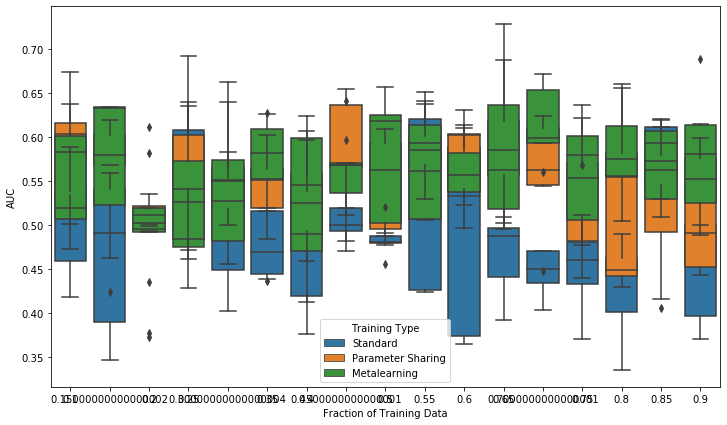

In [26]:
fig = plt.figure(figsize = (12,7))
sns.boxplot(x = 'Fraction of Training Data', y = 'AUC', 
            hue ='Training Type',#, ci = None, linewidth=5, 
             data = results, 
           dodge=False)
#                             .loc[(results['Fraction of Training Data']<.8)&\
#                                (results['Fraction of Training Data']>.2)])
plt.show()

In [30]:
sns.set_theme()

In [37]:
sns.set(font_scale = 1.5)

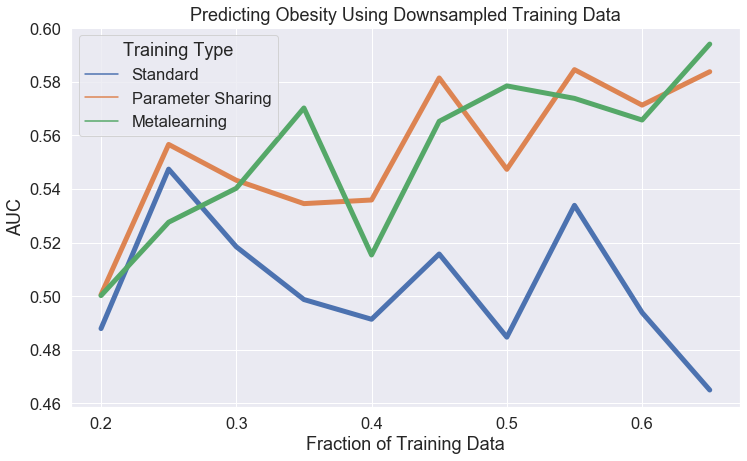

In [59]:
fig = plt.figure(figsize = (12,7))
sns.lineplot(x = 'Fraction of Training Data', y = 'AUC', 
            hue ='Training Type',ci = None, linewidth=5, 
             data = results.loc[(results['Fraction of Training Data']<=.7)&\
                               (results['Fraction of Training Data']>=.2)], 
            estimator=np.mean)
plt.title('Predicting Obesity Using Downsampled Training Data')
# plt.savefig('figures/Obesity_Downsampling_Analysis.png')
plt.show()